$$\large{\mathbf{Instituto\ Superior\ de\ Engenharia\ de\ Lisboa}}$$

$$\large{\mathrm{Licenciatura\ em\ Engenharia\ Informática\ e\ Multimédia}}$$

$$\Large{\mathbf{Codificação\ de\ Sinais\ Multimédia}}$$

$$\normalsize{\mathbf{2º\ Trabalho\ Prático\\}}$$

In [1]:
import numpy as np
import math
import cv2
import os
import sys
import traceback
import heapq
import time
import string
import random
!pip install psutil
import psutil
!pip install humanize
import humanize
!pip install bitarray
from bitarray import bitarray
!pip install GPUtil
import GPUtil as GPU
import matplotlib.pyplot as plt
from pprint import pprint
from enum import Enum, unique

In [2]:
class Notebook():
    """Holds notebook methods and variables."""
    PROJECT = '../../P02/'
    LIBRARY = '../../lib/'
    NOTEBOOK = PROJECT + 'notebooks/'
    RESOURCES = PROJECT + 'resources/raw/'
    OUTPUT = PROJECT + 'resources/processed/'
    GPU = GPU.getGPUs()
    PROCESS = psutil.Process(os.getpid())
    
    @classmethod
    def check_path(cls):
        """Checks the path of this notebook."""
        for path in [cls.PROJECT, cls.LIBRARY, cls.NOTEBOOK, cls.RESOURCES, cls.OUTPUT]:
            try:
                assert os.path.isdir(path), 'Directory not found.'                
                sys.path.insert(0, path)            
            except AssertionError:
                _, _, tb = sys.exc_info()
                tb_info = traceback.extract_tb(tb)
                filename, line, func, text = tb_info[-1]
                print('An error occurred on line {} in statement {}:'.format(line, text))
                sys.exit(0)
                
    @classmethod
    def check_memory(cls):
        """Checks the RAM resources available in this runtime."""
        print('Gen Available RAM: {} | Process Memory Size: {}'
            .format(
                humanize.naturalsize(psutil.virtual_memory().available), 
                humanize.naturalsize(cls.PROCESS.memory_info().rss)))
        for g in cls.GPU:
            print('GPU Available RAM: {0:.1f} GB | Used: {1:.1f} GB | Util {2:0.0f}% | Total {3:.1f} GB'
                .format(
                    g.memoryFree/1000., g.memoryUsed/1000., g.memoryUtil/10., g.memoryTotal/1000.))
                
Notebook.check_path()
Notebook.check_memory()

Gen Available RAM: 399.3 MB | Process Memory Size: 84.9 MB


---
$\normalsize{\mathit{1.\ Elabore\ uma\ função\ que\ gere\ uma\ tabela\ com\ o\ código\ binário\ para\ cada\ símbolo\ de\ um\ dado\ conjunto,\ usando\ o\ método\\ de\ Huffman.\ Esta\ função\ deve\ ter\ como\ parâmetros\ de\ entrada\ um\ conjunto\ de\ símbolos\ e\ as\ suas\ probabilidades\ (ou\ em\\ alternativa\ pode\ usar\ o\ número\ de\ ocorrências\ de\ cada\ símbolo,\ dado\ pelo\ seu\ histograma).\ Também\ pode\ em\ alternativa\\ gerar\ não\ uma\ tabela\ mas\ outra\ estrutura\ de\ dados\ com\ os\ códigos\ pretendidos.
}}$

In [11]:
@unique
class FileType(Enum):
    """Lists type of input files as an integer."""
    TEXT, IMAGE, SOUND = range(3)

    @classmethod
    def get_name(cls, x) -> enumerate.__name__:
        """Returns type name from its value."""
        return [y for y in cls if x == y.value][0]

    @classmethod
    def get_value(cls, x) -> int:
        """Returns type value from its name."""
        return x.value

    @classmethod
    def get_bit_length(cls) -> int:
        """Checks max bit length needed to represent any file type."""
        return list(cls._value2member_map_)[-1].bit_length()

In [12]:
class FileGenerator():
    """Generates a mockup file with custom size and characters for testing purposes."""
    def __init__(self, unique_chars: int, size: int, file_path: str) -> None:
        self.unique_chars = unique_chars
        self.file_path = file_path
        self.size = size

    def id_generator(self, list_chars: str = string.printable) -> str :  
        """Generates a string (from ASCII printable list) with a custom number of uniques."""
        return ''.join(random.choice(list_chars) for _ in range(self.unique_chars))
    
    def text_generator(self) -> None:
        """Writes a text file with a custom size per string."""
        with open(self.file_path, 'w') as f:
            f.write(self.id_generator() * self.size)

In [13]:
char = 256 
size = 1024
name = 'dummy.txt' 
FileGenerator(int(char), int(size), Notebook.RESOURCES + name).text_generator()

In [14]:
class Encoder:
    """Encodes any symbol source using Huffman frequency-sorted binary tree encoding."""

    def __init__(self, source: str) -> None:
        try:
            self.type = None
            self.heap = None
            self.dict = None
            self.entropy = None
            self.information = None
            self.efficiency = None
            assert os.path.isfile(source), 'Incorrect file path.'
            self.source = source
            self.stream, self.shape = self.load_file()
            assert self.stream is not None, 'Error found while loading byte stream.'
            self.set, self.frequency = np.unique(self.stream, return_counts=True)
            self.table = self.encode_heap()
        except AssertionError:
            _, _, tb = sys.exc_info()
            tb_info = traceback.extract_tb(tb)
            filename, line, func, text = tb_info[-1]
            print('An error occurred on line {} in statement {}:'.format(line, text))
            sys.exit(0)

    def stats(self) -> None:
        """Plots an histogram of the source symbol distribution."""
        plt.hist(self.stream, range(256), facecolor='blue', alpha=0.5)
        plt.xlabel('Symbol')
        plt.ylabel('Occurrences')
        plt.title('Histogram of Source (' + self.get_filename() + ')')
        plt.grid(True)
        plt.show()

    def load_file(self) -> (np.ndarray, np.ndarray):
        """Loads file as an 8 bit symbol stream and classifies it by its extension name."""
        if self.source.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp')):
            self.type = FileType.IMAGE
            output = cv2.imread(self.source, cv2.COLOR_BGR2GRAY)
            return output.ravel(), output.shape
        elif self.source.lower().endswith(('.txt', '.pdf')):
            self.type = FileType.TEXT
            output = np.fromfile(self.source, np.uint8)
            return output, (output.shape[0], 0)
        elif self.source.lower().endswith('.mp3'):
            self.type = FileType.SOUND
            output = np.fromfile(self.source, np.uint8)
            return output, (output.shape[0], 0)
        else:
            raise ValueError('Unspecified encoding for this file type.')

    def get_stream(self):
        """Returns the raw stream as read from file."""
        return self.stream

    def get_type(self):
        """Returns the file type."""
        return self.type

    def get_table(self):
        """Returns the Huffman dictionary."""
        return self.table

    def get_shape(self):
        """Returns the shape of the original file."""
        return self.shape

    def get_set(self):
        """Returns a custom set of unique symbols in the file."""
        return self.set

    def get_frequency(self):
        """Returns the respective occurrences of symbols."""
        return self.frequency

    def get_entropy(self):
        """Returns the source original entropy level."""
        return self.entropy

    def get_information(self):
        """Returns the encoding information level."""
        return self.information

    def get_filename(self):
        """Returns the source filename."""
        return self.source.split('/')[-1]

    def encode_heap(self) -> dict:
        """Encodes a Huffman-type binary tree using a heap queue to order occurrence of symbols."""
        self.heap = [[self.frequency[i], [self.set[i], ()]] for i in range(len(self.set))]
        heapq.heapify(self.heap)
        while len(self.heap) > 1:
            first = heapq.heappop(self.heap)
            second = heapq.heappop(self.heap)
            for pair in first[1:]:
                pair[1] = (0,) + pair[1]
            for pair in second[1:]:
                pair[1] = (1,) + pair[1]
            heapq.heappush(self.heap, [first[0] + second[0]] + first[1:] + second[1:])
        self.heap = sorted(heapq.heappop(self.heap)[1:], key=lambda p: (len(p[-1]), p))
        self.heap = {node[0]: np.asarray(node[1], dtype=np.uint8) for node in self.heap}
        return self.heap

    @staticmethod
    def recursive(data: dict) -> dict:
        """Encodes a Huffman-type binary tree in dictionary format (alternative to previous)."""
        if len(data) == 1:
            return dict(zip(data.keys(), np.array([0], dtype=np.uint8)))
        if len(data) == 2:
            return dict(zip(data.keys(), np.array([0, 1], dtype=np.uint8)))
        indexes = sorted(data.items(), key=lambda x: x[1])
        c0, c1 = indexes[0][0], indexes[1][0]
        f0, f1 = data.pop(c0), data.pop(c1)
        data[(c0,) + (c1,)] = f0 + f1
        table = Encoder.recursive(data)
        code = table.pop((c0,) + (c1,))
        table[c0], table[c1] = np.append(code, np.uint8(0)), np.append(code, np.uint8(1))
        return table

    def encode_dict(self) -> dict:
        """Sets up data for and calls recursive function."""
        data = dict(zip(self.set, self.frequency))
        self.dict = Encoder.recursive(data)
        return self.dict

    def measure_entropy(self, frequency: np.ndarray, data: np.ndarray) -> np.float64:
        """Calculates source entropy level."""
        self.entropy = [-sum(p * np.log2(p) for p in np.hstack(np.array([frequency / data.size])))][0]
        return self.entropy

    def measure_information(self, table: dict) -> np.float64:
        """Calculates encoding information level."""
        self.information = sum([code.size for code in table.values()] * (self.frequency / len(self.stream)))
        return self.information

    def measure_efficiency(self) -> np.float64:
        """Calculates encoding efficiency based on entropy/information level."""
        self.efficiency = self.get_entropy() / self.get_information()
        return self.efficiency * 100

    def benchmark(self) -> None:
        """Compares times from both encoding methods provided."""
        print('\n:: Running encoder for %s ::\n' % self.source.split('/')[-1])
        print('Heaptime: ', end = '')
        self.heaptime = %timeit -n1 -r3 -o huffman.encode_heap()
        print('Dicttime: ', end = '')
        self.dictime = %timeit -n1 -r3 -o huffman.encode_dict()
        print()


Encoding dummy.txt (266.24 kbytes)


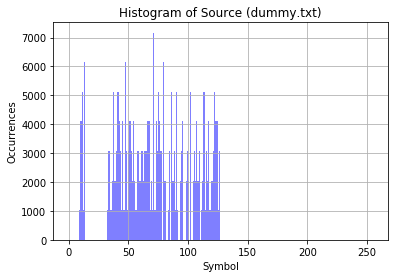


Source Entropy Level: 6.327 bit/symbol

Excerpt of Huffman Table:

{10: array([0, 1, 0, 1, 0, 0], dtype=uint8),
 11: array([1, 1, 0, 0, 0, 0], dtype=uint8),
 13: array([1, 1, 1, 0, 1, 0], dtype=uint8),
 37: array([1, 1, 0, 0, 0, 1], dtype=uint8),
 41: array([1, 1, 0, 0, 1, 0], dtype=uint8),
 42: array([0, 1, 0, 1, 1, 1], dtype=uint8),
 45: array([0, 1, 1, 0, 0, 0], dtype=uint8),
 47: array([1, 1, 1, 1, 0, 1], dtype=uint8),
 51: array([0, 1, 1, 0, 1, 0], dtype=uint8),
 54: array([0, 1, 1, 0, 1, 1], dtype=uint8),
 61: array([0, 0, 0, 0, 0, 0], dtype=uint8),
 63: array([0, 0, 0, 0, 0, 1], dtype=uint8),
 64: array([0, 0, 0, 0, 1, 0], dtype=uint8),
 71: array([0, 1, 0, 0, 0], dtype=uint8),
 79: array([0, 0, 0, 1, 1], dtype=uint8)}
...

Encoding Information Level: 6.708 bit/symbol

Encoding Efficiency Level: 94.33 %

Encoding time: 0.01396 seconds




Encoding helloworld.txt (0.022 kbytes)


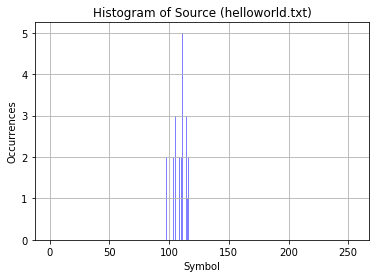


Source Entropy Level: 3.045 bit/symbol

Excerpt of Huffman Table:

{97: array([1, 1, 0, 1], dtype=uint8),
 103: array([1, 1, 1, 0], dtype=uint8),
 105: array([1, 0, 0], dtype=uint8),
 108: array([1, 1, 1, 1], dtype=uint8),
 110: array([0, 0, 0], dtype=uint8),
 111: array([0, 1], dtype=uint8),
 114: array([1, 0, 1], dtype=uint8),
 115: array([1, 1, 0, 0], dtype=uint8),
 116: array([0, 0, 1], dtype=uint8)}
...

Encoding Information Level: 3.409 bit/symbol

Encoding Efficiency Level: 89.32 %

Encoding time: 0.00198 seconds




Encoding ubuntu_server_guide.txt (763.396 kbytes)


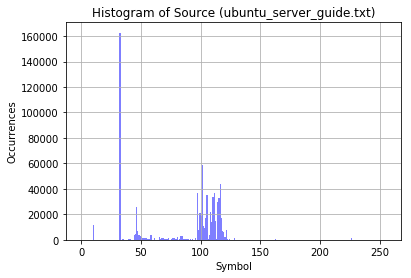


Source Entropy Level: 4.697 bit/symbol

Excerpt of Huffman Table:

{10: array([1, 0, 0, 1, 1, 1], dtype=uint8),
 32: array([0, 1], dtype=uint8),
 46: array([1, 0, 1, 0, 1], dtype=uint8),
 97: array([0, 0, 0, 1], dtype=uint8),
 99: array([0, 0, 1, 1, 1], dtype=uint8),
 100: array([0, 0, 0, 0, 1], dtype=uint8),
 101: array([1, 1, 0, 0], dtype=uint8),
 102: array([1, 0, 0, 1, 1, 0], dtype=uint8),
 105: array([1, 1, 1, 1, 1], dtype=uint8),
 108: array([1, 0, 0, 1, 0], dtype=uint8),
 110: array([1, 1, 1, 0, 1], dtype=uint8),
 111: array([0, 0, 1, 0], dtype=uint8),
 114: array([1, 1, 0, 1, 1], dtype=uint8),
 115: array([1, 1, 1, 0, 0], dtype=uint8),
 116: array([1, 0, 0, 0], dtype=uint8)}
...

Encoding Information Level: 9.176 bit/symbol

Encoding Efficiency Level: 51.18 %

Encoding time: 0.03891 seconds




Encoding iliad.txt (808.298 kbytes)


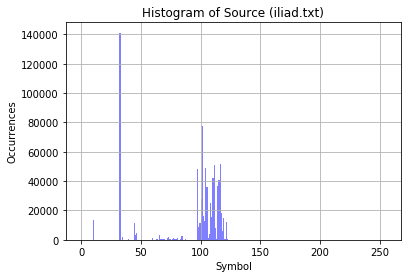


Source Entropy Level: 4.385 bit/symbol

Excerpt of Huffman Table:

{10: array([1, 1, 0, 0, 0, 0], dtype=uint8),
 32: array([1, 1, 1], dtype=uint8),
 44: array([0, 1, 1, 0, 0, 0], dtype=uint8),
 97: array([0, 1, 1, 1], dtype=uint8),
 100: array([1, 0, 1, 1, 1], dtype=uint8),
 101: array([0, 0, 1], dtype=uint8),
 104: array([1, 0, 0, 0], dtype=uint8),
 105: array([1, 1, 0, 1, 1], dtype=uint8),
 108: array([1, 0, 1, 1, 0], dtype=uint8),
 110: array([0, 1, 0, 1], dtype=uint8),
 111: array([1, 0, 0, 1], dtype=uint8),
 114: array([0, 0, 0, 0], dtype=uint8),
 115: array([0, 1, 0, 0], dtype=uint8),
 116: array([1, 0, 1, 0], dtype=uint8),
 117: array([0, 0, 0, 1, 0], dtype=uint8)}
...

Encoding Information Level: 11.889 bit/symbol

Encoding Efficiency Level: 36.88 %

Encoding time: 0.03691 seconds




Encoding ecg.txt (259.112 kbytes)


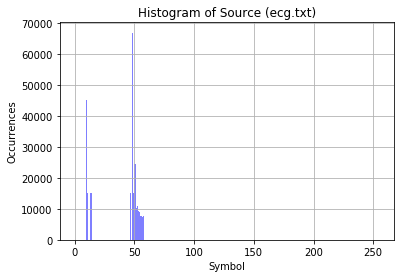


Source Entropy Level: 3.395 bit/symbol

Excerpt of Huffman Table:

{9: array([1, 1, 1], dtype=uint8),
 10: array([0, 1, 0, 0], dtype=uint8),
 13: array([0, 1, 0, 1], dtype=uint8),
 32: array([0, 1, 1, 1, 0, 0, 1, 0, 1], dtype=uint8),
 46: array([0, 0, 1, 1], dtype=uint8),
 48: array([1, 0], dtype=uint8),
 49: array([0, 1, 1, 0], dtype=uint8),
 50: array([0, 0, 0], dtype=uint8),
 51: array([1, 1, 0, 1, 1], dtype=uint8),
 52: array([0, 0, 1, 0], dtype=uint8),
 53: array([1, 1, 0, 1, 0], dtype=uint8),
 54: array([1, 1, 0, 0, 1], dtype=uint8),
 55: array([0, 1, 1, 1, 1], dtype=uint8),
 56: array([0, 1, 1, 1, 0, 1], dtype=uint8),
 57: array([1, 1, 0, 0, 0], dtype=uint8)}
...

Encoding Information Level: 4.383 bit/symbol

Encoding Efficiency Level: 77.47 %

Encoding time: 0.00901 seconds




Encoding HenryMancini-PinkPanther30s.mp3 (779.228 kbytes)


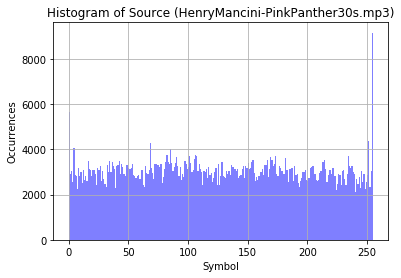


Source Entropy Level: 7.985 bit/symbol

Excerpt of Huffman Table:

{0: array([0, 1, 0, 0, 0, 1, 0], dtype=uint8),
 1: array([0, 1, 1, 0, 0, 1, 1, 0], dtype=uint8),
 2: array([0, 1, 1, 1, 1, 1, 0, 1], dtype=uint8),
 3: array([0, 0, 0, 1, 0, 1, 1, 1], dtype=uint8),
 4: array([1, 1, 1, 1, 1, 0, 1, 1], dtype=uint8),
 5: array([0, 1, 0, 1, 0, 0, 0, 0], dtype=uint8),
 6: array([0, 1, 0, 0, 0, 1, 1, 1], dtype=uint8),
 8: array([1, 0, 1, 1, 0, 0, 0, 0], dtype=uint8),
 9: array([0, 1, 0, 0, 0, 0, 0, 1], dtype=uint8),
 10: array([0, 1, 1, 1, 0, 1, 0, 0], dtype=uint8),
 11: array([0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8),
 12: array([1, 0, 0, 1, 0, 0, 1, 1], dtype=uint8),
 13: array([0, 0, 1, 0, 0, 1, 1, 0], dtype=uint8),
 14: array([0, 1, 0, 0, 1, 0, 1, 0], dtype=uint8),
 255: array([1, 1, 0, 0, 0, 0, 1], dtype=uint8)}
...

Encoding Information Level: 8.008 bit/symbol

Encoding Efficiency Level: 99.72 %

Encoding time: 0.10874 seconds




Encoding lena.tiff (262.494 kbytes)


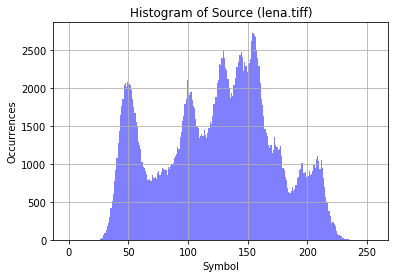


Source Entropy Level: 7.446 bit/symbol

Excerpt of Huffman Table:

{43: array([0, 0, 1, 0, 1, 0, 0], dtype=uint8),
 44: array([0, 0, 1, 1, 1, 0, 1], dtype=uint8),
 45: array([0, 1, 0, 1, 0, 1, 1], dtype=uint8),
 46: array([1, 0, 0, 0, 0, 1, 0], dtype=uint8),
 47: array([1, 0, 0, 1, 0, 0, 1], dtype=uint8),
 48: array([1, 0, 0, 0, 0, 0, 0], dtype=uint8),
 49: array([1, 0, 0, 1, 0, 1, 0], dtype=uint8),
 50: array([1, 0, 0, 0, 1, 0, 1], dtype=uint8),
 51: array([1, 0, 0, 0, 0, 1, 1], dtype=uint8),
 52: array([0, 1, 1, 1, 1, 0, 1], dtype=uint8),
 53: array([0, 1, 0, 1, 1, 0, 0], dtype=uint8),
 54: array([0, 0, 1, 1, 1, 0, 0], dtype=uint8),
 55: array([0, 0, 1, 0, 1, 1, 0], dtype=uint8),
 56: array([0, 0, 0, 1, 0, 0, 1], dtype=uint8),
 57: array([0, 0, 0, 0, 0, 1, 1], dtype=uint8)}
...

Encoding Information Level: 7.819 bit/symbol

Encoding Efficiency Level: 95.23 %

Encoding time: 0.01397 seconds





In [15]:
input_streams  = []
huffman_tables = []
file_types     = []
dimensions     = []
input_files    = ['dummy.txt', 
                  'helloworld.txt', 
                  'ubuntu_server_guide.txt', 
                  'iliad.txt', 
                  'ecg.txt', 
                  'HenryMancini-PinkPanther30s.mp3',
                  'lena.tiff']
    
for f in range(len(input_files)):
    print('\nEncoding %s (%s kbytes)' 
          % (input_files[f], (round((os.path.getsize(Notebook.RESOURCES + input_files[f])/1000.), 3))))
    start = time.time()
    huffman = Encoder(Notebook.RESOURCES + input_files[f])
    end = time.time()
    input_streams.append(huffman.get_stream())
    huffman_tables.append(huffman.encode_heap())
    file_types.append(huffman.get_type())
    dimensions.append(huffman.get_shape())
    huffman.stats()
    print('\nSource Entropy Level: %s bit/symbol' 
          % round(huffman.measure_entropy(huffman.get_frequency(), huffman.get_stream()), 3))
    print('\nExcerpt of Huffman Table:\n')
    pprint(dict(list(huffman.get_table().items())[:15]))
    print('...')
    print('\nEncoding Information Level: %s bit/symbol' 
          % round(huffman.measure_information(huffman.get_table()), 3))
    print('\nEncoding Efficiency Level: %s %%' 
          % round(huffman.measure_efficiency(), 2))
    print('\nEncoding time: %s seconds\n' 
          % round((end-start), 5))
    #huffman.benchmark()
    print('\n')

---
$\normalsize{\mathit{2.\ Elabore\ uma\ função\ que\ dada\ uma\ mensagem\ (sequência\ de\ símbolos)\ e\ a\ tabela\ do\ ponto\ anterior,\ retorne\ uma\ sequência\ de\ bits\ com\ a\ mensagem\ codificada.}}$



In [16]:
class Writer:
    """Translates a given message with Huffman encoding and compresses it to file in binary format."""

    def __init__(self, message: np.ndarray, table: dict, path: str,
                 filename: str, file_type: FileType, dimensions: tuple) -> None:
        self.max_chunk = 52428800
        self.window = None
        self.height = None
        self.width = None
        self.count = None
        self.sizes = None
        self.codes = None
        self.symbols = None
        self.data = None
        self.stream = None
        self.file_type_size = FileType.get_bit_length()
        self.message = message
        self.table = table
        self.path = path
        self.filename = filename
        self.file_type = file_type
        self.dimensions = dimensions
        self.header = self.set_header()
        self.packet = self.set_packet()
        self.output = path + '{}.txt'.format(self.filename.split('.')[0] + 'compressed')
        Writer.write(self.packet, self.output)

    def set_header(self) -> np.ndarray:
        """Sets up a header with the Huffman table to allow for decoding on the receptor."""
        self.window = Writer.count_bits(Writer.get_longest(self.table))
        self.height = np.concatenate([np.unpackbits(np.uint8((np.uint16(self.dimensions[0])
                                                              & (0b11111111 << x)) >> x)) for x in np.array([8, 0])]) \
            if self.file_type == FileType.IMAGE else np.zeros(16).astype(np.uint8)
        self.width = np.concatenate([np.unpackbits(np.uint8((np.uint16(self.dimensions[1])
                                                             & (0b11111111 << x)) >> x)) for x in np.array([8, 0])]) \
            if self.file_type == FileType.IMAGE else np.zeros(16).astype(np.uint8)
        self.count = Writer.count_uniques(self.table)
        self.sizes = Writer.concat_sizes(self.table, self.window)
        self.codes = Writer.concat_codes(self.table)
        self.symbols = Writer.concat_symbols(self.table)
        return np.concatenate((
            Writer.convert_binary(FileType.get_value(self.file_type))[8 - self.file_type_size:],
            Writer.convert_binary(self.window),
            self.height,
            self.width,
            self.count,
            self.sizes,
            self.codes,
            self.symbols
        ))

    def set_packet(self) -> bytes:
        """Adds the header to the encoded data to form a packet and sets it as a byte array."""
        self.data = self.encode_data()
        self.stream = np.concatenate((Writer.pad_zeros(np.concatenate((self.header, self.data)))))
        return np.packbits(self.stream).tobytes()

    def encode_data(self) -> np.ndarray:
        """Encodes data (if message stream is larger than 50MB splits array to reduce RAM expansion)."""
        if len(self.message) < self.max_chunk:
            return np.concatenate([self.table.get(letter) for letter in self.message])
        else:
            return np.concatenate([self.table.get(letter)
                                   for self.message in np.array_split(self.message, len(self.message) / self.max_chunk)
                                   for letter in self.message])

    def get_output_name(self) -> str:
        """Returns the compressed file name."""
        return self.output

    def get_compressed_size(self) -> str:
        """Returns the compressed file size."""
        return str(round(os.path.getsize(self.output) / 1000., 3)) + ' kbytes'

    def get_header_size(self) -> int:
        """Returns the header size."""
        return len(np.packbits(self.header))

    def get_data_size(self) -> int:
        """Returns the data size."""
        return len(np.packbits(self.data))

    @staticmethod
    def write(packet: bytes, output: str) -> None:
        """Writes a packet to file."""
        with open(output, 'wb') as file:
            file.write(packet)

    @staticmethod
    def pad_zeros(array: np.ndarray) -> (np.ndarray, np.ndarray):
        """Pads with zeros to form an 8 bit modulus array and returns padding."""
        padding = ((8 - array.size % 8) % 8)
        return np.pad(array, (0, padding), 'constant'), np.unpackbits(np.uint8(padding))

    @staticmethod
    def get_longest(table: dict) -> int:
        """Returns the longest code in a table."""
        return max((len(v)) for v in table.values())

    @staticmethod
    def count_bits(number: int) -> int:
        """Returns the number of bits of an integer."""
        return len(bin(number).split('b')[-1])

    @staticmethod
    def count_uniques(table: dict) -> np.ndarray:
        """Returns the number different symbols in a table."""
        return np.unpackbits(np.uint8(len(table.keys()) - 1))

    @staticmethod
    def concat_sizes(table: dict, window: int) -> np.ndarray:
        """Returns a concatenated stream with code sizes, with fixed-by-largest binary window for each."""
        return np.concatenate(
            [np.unpackbits(np.uint8(v))[8 - window:] for v in sorted((len(v)) for v in table.values())])

    @staticmethod
    def concat_codes(table: dict) -> np.ndarray:
        """Returns a concatenated stream with codes, with no padding for each."""
        return np.concatenate([table[k] for v, k in sorted((len(v), k) for (k, v) in table.items())], 0)

    @staticmethod
    def concat_symbols(table: dict) -> np.ndarray:
        """Returns a concatenated stream with symbols, with ASCII 8 bit array for each."""
        return np.concatenate([
            np.unpackbits(np.uint8(k)) for v, k in sorted((len(v), k) for (k, v) in table.items())], 0)

    @staticmethod
    def convert_binary(value: int) -> np.ndarray:
        """Converts a given integer to an 8 bit binary format array."""
        return np.unpackbits(np.uint8(value))


In [17]:
output_files     = []
compressed_sizes = []

for f in range(len(input_files)):
    print('Writting %s (%s) kbytes\n' 
          % (input_files[f], (str(round((os.path.getsize(Notebook.RESOURCES + input_files[f])/1000.), 3)))))
    start = time.time()
    writer = Writer(input_streams[f], huffman_tables[f], Notebook.OUTPUT, input_files[f], file_types[f], dimensions[f])
    output_files.append(writer.get_output_name())
    compressed_sizes.append(writer.get_compressed_size())   
    end = time.time()   
    print('Written %s (%s)\n' 
          % (writer.get_output_name().split('/')[-1], writer.get_compressed_size()))
    print('Header: {0:.3f} kbytes | Payload: {1:.3f} kbytes | Ratio {2:.3f}%\n'
          .format(writer.get_header_size()/1000., writer.get_data_size()/1000., 
                  writer.get_header_size()/writer.get_data_size()))
    print('Writting time: %s seconds\n' % round((end-start), 5))
    print('\n')

Writting dummy.txt (266.24) kbytes

Written dummycompressed.txt (211.933 kbytes)

Header: 0.220 kbytes | Payload: 211.712 kbytes | Ratio 0.001%

Writting time: 0.16984 seconds



Writting helloworld.txt (0.022) kbytes

Written helloworldcompressed.txt (0.032 kbytes)

Header: 0.023 kbytes | Payload: 0.009 kbytes | Ratio 2.556%

Writting time: 0.00199 seconds



Writting ubuntu_server_guide.txt (763.396) kbytes

Written ubuntu_server_guidecompressed.txt (451.757 kbytes)

Header: 0.300 kbytes | Payload: 451.457 kbytes | Ratio 0.001%

Writting time: 0.38597 seconds



Writting iliad.txt (808.298) kbytes

Written iliadcompressed.txt (446.898 kbytes)

Header: 0.218 kbytes | Payload: 446.679 kbytes | Ratio 0.000%

Writting time: 0.55752 seconds



Writting ecg.txt (259.112) kbytes

Written ecgcompressed.txt (111.793 kbytes)

Header: 0.148 kbytes | Payload: 111.645 kbytes | Ratio 0.001%

Writting time: 0.1885 seconds



Writting HenryMancini-PinkPanther30s.mp3 (779.228) kbytes

Written HenryMa

<hr>
># 3.

> Elabore uma função ("**descodifica**") que dada uma sequência de bits (mensagem codificada) e a tabela do ponto
1, retorne uma sequência de símbolos (mensagem descodificada).

In [18]:
class Reader:
    """Reads a compressed file and decodes it after rebuilding its Huffman table from header."""

    def __init__(self, path: str) -> None:
        self.file_type_size = FileType.get_bit_length()
        self.window_size = 8
        self.file_type = None
        self.window = None
        self.height = None
        self.width = None
        self.count = None
        self.sizes = None
        self.codes = None
        self.symbols = None
        self.padding = None
        try:
            assert os.path.isfile(path), 'Incorrect file path. File not found.'
            self.raw_stream = Reader.load_stream(path)
            assert self.raw_stream is not None, 'Error found while loading byte stream. Message is null.'
            self.dictionary = self.rebuild_dict()
            assert self.dictionary is not None, 'Error found while rebuilding dictionary. Table is null.'
            self.decoded_message = Reader.decode_bit_stream(self.raw_stream, self.dictionary)
            assert len(self.decoded_message) > 0, 'Error found while decoding message. String is empty.'
            if self.file_type == FileType.TEXT:
                self.binary_stream, self.text_excerpt = self.get_decoded_text()
                print('Excerpt: "' + str(self.text_excerpt[:100]) + '" ')
            elif self.file_type == FileType.IMAGE:
                self.binary_stream, self.image_sample = self.get_decoded_image()
                plt.imshow(self.image_sample, cmap='gray', vmin=0, vmax=255)
                plt.show()
            elif self.file_type == FileType.SOUND:
                self.binary_stream = self.get_decoded_sound()
        except AssertionError:
            _, _, tb = sys.exc_info()
            tb_info = traceback.extract_tb(tb)
            filename, line, func, text = tb_info[-1]
            print('An error occurred on line {} in statement {}:'.format(line, text))
            sys.exit(0)

    def get_binary_stream(self) -> np.ndarray:
        """Returns the decompressed data as a binary stream."""
        return self.binary_stream

    def get_decoded_text(self) -> tuple:
        """Return the decompressed data as a string."""
        return np.hstack([Reader.convert_binary(ord(value)) for value in self.decoded_message]), \
            ''.join(self.decoded_message)

    def get_decoded_image(self) -> tuple:
        """Return the decompressed data as a 2D array."""
        return np.hstack([Reader.convert_binary(int(value)) for value in self.decoded_message]), \
            (np.asarray(self.decoded_message).reshape(self.width, self.height))

    def get_decoded_sound(self) -> np.ndarray:
        """Return the decompressed data as a 1D array."""
        return np.hstack([Reader.convert_binary(int(value)) for value in self.decoded_message])

    def rebuild_dict(self) -> dict:
        """Rebuilds the compressed dictionary included in the compressed file."""
        self.file_type = FileType.get_name(Reader.array_to_int(
            self.pop_first(self.file_type_size), self.file_type_size))
        self.window = Reader.array_to_int(self.pop_first(8), 8)
        self.height = np.packbits(self.pop_first(8))[0] << 8 | np.packbits(self.pop_first(8))[0]
        self.width = np.packbits(self.pop_first(8))[0] << 8 | np.packbits(self.pop_first(8))[0]
        self.count = Reader.array_to_int(self.pop_first(8), 8) + 1
        self.sizes = np.hstack(list(map(lambda x: Reader.string_to_int(Reader.array_to_string(
            self.pop_first(self.window))), range(self.count))))
        self.codes = np.asarray(list(map(lambda x: bitarray(Reader.array_to_string(
            self.pop_first(x))), self.sizes)))

        if self.file_type == FileType.TEXT:
            self.symbols = np.hstack(list(map(lambda x: chr(int(np.packbits(
                np.uint8(self.pop_first(8))))), range(self.count)))).astype(str)
        elif self.file_type == FileType.IMAGE or self.file_type == FileType.SOUND:
            self.symbols = np.hstack(list(map(lambda x: np.packbits(
                np.uint8(self.pop_first(8))), range(self.count))))

        self.padding = self.pop_last(int(np.packbits(np.uint8(self.pop_last(8)))))
        return dict(zip(self.symbols, self.codes))

    def pop_first(self, limit: int) -> np.ndarray:
        """Removes and returns the first elements of an array (to given limit)."""
        value = self.raw_stream[:limit]
        self.raw_stream = self.raw_stream[limit:]
        return value

    def pop_last(self, limit: int) -> np.ndarray:
        """Removes and returns the last elements of an array (to given limit)."""
        value = self.raw_stream[self.raw_stream.size - limit:]
        self.raw_stream = self.raw_stream[:self.raw_stream.size - limit]
        return value

    @staticmethod
    def decode_bit_stream(message: np.ndarray, table: dict) -> str:
        """Decodes a message using a table."""
        return bitarray(Reader.array_to_string(message)).decode(table)

    @staticmethod
    def array_to_int(array: np.ndarray, size: int) -> int:
        """Converts a 1D binary array to integer value."""
        return array.dot(2 ** np.arange(size)[::-1])

    @staticmethod
    def array_to_string(array: np.ndarray) -> str:
        """Converts a 1D binary array to string."""
        return ''.join(array.astype(str))

    @staticmethod
    def string_to_int(string: str) -> int:
        """Converts a string to integer."""
        return int(string, 2)

    @staticmethod
    def get_shortest_size(array: np.ndarray) -> np.ndarray:
        """Returns the lowest value in a array."""
        return [min(a for a in array)][0]

    @staticmethod
    def load_stream(path: str) -> np.ndarray:
        """Reads file as a series of 8 bit symbols."""
        return np.unpackbits((np.fromfile(path, np.uint8)))

    @staticmethod
    def convert_binary(value: int) -> np.ndarray:
        """Converts a binary 8-element array into its integer value."""
        return np.unpackbits(np.uint8(value))

    @staticmethod
    def check_errors(original: np.ndarray, transformed: np.ndarray) -> bool:
        """Compares two arrays."""
        return np.array_equal(original, transformed)

    @staticmethod
    def compression_rate(original_file: str, compressed_file: np.ndarray) -> (float, float, float):
        """Returns a ratio between two file sizes."""
        ini_size = os.path.getsize(original_file)
        end_size = os.path.getsize(compressed_file)
        return round(ini_size / 1000., 3), round(end_size / 1000., 3), round(1 - end_size / ini_size, 2)



Reading ../../P02/resources/processed/dummycompressed.txt (211.933  kbytes)

Excerpt: "6^Z4"[PS6Z0%VcGW6OH9~_ql/7^jC(@~-^3A:fxw)kL%*/;uIWOFsZKhhd=q@suTOqrIkCV9"kBwV
5zz50|I2p2i$)X
k$" 

Lossless Compression (No Errors): True

Compression Level: Original 266.24 | Compressed 211.933 | Ratio 0.2%

Reading time: 2.60113 seconds




Reading ../../P02/resources/processed/helloworldcompressed.txt (0.032  kbytes)

Excerpt: "otorrinolaringologista" 

Lossless Compression (No Errors): True

Compression Level: Original 0.022 | Compressed 0.032 | Ratio -0.45%

Reading time: 0.00445 seconds




Reading ../../P02/resources/processed/ubuntu_server_guidecompressed.txt (451.757  kbytes)

Excerpt: "Ubuntu Server GuideUbuntu Server Guide
Copyright Â© 2016 Contributors to the document
              " 

Lossless Compression (No Errors): True

Compression Level: Original 763.396 | Compressed 451.757 | Ratio 0.41%

Reading time: 6.81982 seconds




Reading ../../P02/resources/processed/iliadcompressed.tx

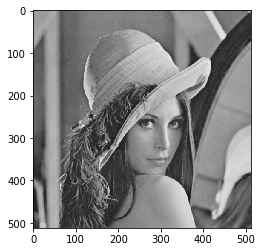


Lossless Compression (No Errors): False

Compression Level: Original 262.494 | Compressed 245.303 | Ratio 0.07%

Reading time: 2.47942 seconds





In [19]:
decoded_files = []

for f in range(len(output_files)):
    start = time.time()
    print('\nReading %s (%s  kbytes)\n' 
          % (output_files[f], (str(round((os.path.getsize(output_files[f])/1000.), 3)))))  
    reader = Reader(output_files[f])
    end = time.time()
    print('\nLossless Compression (No Errors): %s' 
          % reader.check_errors(Reader.load_stream(Notebook.RESOURCES + input_files[f]), reader.get_binary_stream()))
    print('\nCompression Level: Original %s | Compressed %s | Ratio %s%%' 
          % (reader.compression_rate(Notebook.RESOURCES + input_files[f], output_files[f])))
    print('\nReading time: %s seconds\n' % round((end-start), 5))
    print('\n')

<hr>
># 4.

> Elabore uma função ("**escrever**") que dada uma sequência de bits (mensagem codificada) e o nome do ficheiro,
escreva a sequência de bits para o ficheiro.

<hr>
># 5.

> Elabore uma função ("**ler**") que dado o nome do ficheiro, leia uma sequência de bits (mensagem codificada)
contida no ficheiro.

<hr>
># 6.

> Teste as funções elaboradas usando para o efeito vários ficheiros com diferentes tipos de média:
>
>  <span style="font-family: Helvetica; font-size: 1em;">IMAGEM</span>
>    : Use para o efeito a imagem “Lena.tif” em tons de cinzento.  
>  <span style="font-family: Helvetica; font-size: 1em;">TEXTO</span>
>    : Use os ficheiros “ubuntu_server_guide.pdf” e “ubuntu_server_guide.txt”.  
>  <span style="font-family: Helvetica; font-size: 1em;">ÁUDIO</span>
>    : Use o ficheiro “HenryMancini-PinkPanther30s.mp3”.  
>  <span style="font-family: Helvetica; font-size: 1em;">MIDI</span>
>    : Use o ficheiro “HenryMancini-PinkPanther.mid”.  
>  <span style="font-family: Helvetica; font-size: 1em;">ECG</span>
>   : Eletrocardiograma - use o ficheiro “ecg.txt”.  


>## a) 

> Gere o código usando a função realizada no ponto 1. Meça o tempo que demora a função

<hr>
>## b) 

> Meça a entropia e o número médio de bits por símbolo. Calcule a eficiência.

<hr>
>## c) 

> Faça a codificação da mensagem contida no ficheiro (usando a função realizada no ponto 2). Meça o tempo
que a função demora a fazer a codificação

<hr>
>## d) 

> Grave um ficheiro com a mensagem codificada, usando a função realizada no ponto 4. Veja o tamanho do
ficheiro.

<hr>
>## e) 

> Leia do ficheiro o conjunto de bits, usando a função realizada no ponto 5.

<hr>
>## f) 

> Faça a descodificação da mensagem (usando a função realizada no ponto 3.) Meça o tempo que a função
demora a fazer a descodificação.



<hr>
>## g) 

> Compare a mensagem descodificada com a original e verifique que são iguais (erro nulo)